In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os


pd.set_option('display.max_colwidth', -1)
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [18, 8]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  if __name__ == '__main__':


In [ ]:

anime_df = pd.read_csv('animeno.csv')
print('anime_df shape:', anime_df.shape)

anime_df shape: (12291, 8)


In [ ]:
anime_df.head()

,Unnamed: 0,anime_id,name,genre,type,episodes,rating,members
0,0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Military, Shounen",TV,64,9.26,793665
2,2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen",TV,51,9.25,114262
3,3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen",TV,51,9.16,151266


## Data Cleaning

- Removing all null values.

In [ ]:
null_features = anime_df.columns[anime_df.isna().any()]
anime_df[null_features].isna().sum()

genre     62 
type      25 
rating    230
dtype: int64

In [ ]:
anime_df.dropna(inplace=True)

## Exploratory data analysis

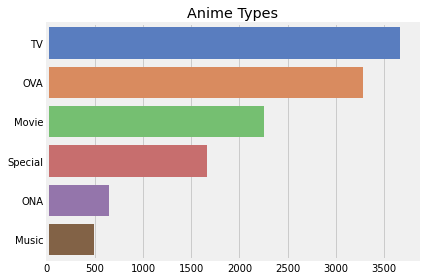

In [ ]:
type_count = anime_df['type'].value_counts()

sns.barplot(x=type_count.values,
            y=type_count.index,
            palette='muted').set_title('Anime Types')

plt.tight_layout()
plt.show()

## What genres are in the anime dataset?

In [ ]:
from collections import defaultdict

all_genres = defaultdict(int)

for genres in anime_df['genre']:
    for genre in genres.split(','):
        all_genres[genre.strip()] += 1

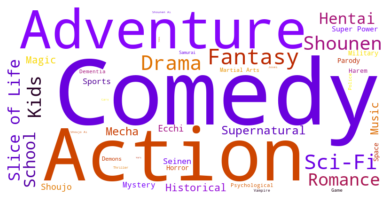

In [ ]:
from wordcloud import WordCloud

genres_cloud = WordCloud(width=800, height=400, background_color='white', colormap='gnuplot').generate_from_frequencies(all_genres)

plt.imshow(genres_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Which anime has a longest episodes?

- In the data set, episodes datatype is object, and not integer 
- because episodes has an Unknown values, which means that the anime is still ongoing


In [ ]:
anime_df[anime_df['episodes'] == 'Unknown']['name'][:10]

74      One Piece                             
252     Detective Conan                       
615     Naruto: Shippuuden                    
991     Crayon Shin-chan                      
1021    Tanaka-kun wa Itsumo Kedaruge Specials
1272    Yu☆Gi☆Oh! Arc-V                       
1309    Doraemon (2005)                       
1927    Dimension W: W no Tobira Online       
1929    Dragon Ball Super                     
1992    Aggressive Retsuko                    
Name: name, dtype: object

In [ ]:
episodes_count = anime_df[anime_df['episodes'] != 'Unknown'][['name', 'episodes']]
episodes_count['episodes'] = pd.to_numeric(episodes_count['episodes'])

episodes_count.query('episodes>1000')

#shows anime with episodes greater than 1000

,name,episodes
929,Doraemon (1979),1787
5358,Manga Nippon Mukashibanashi (1976),1471
6294,Oyako Club,1818
6578,Hoka Hoka Kazoku,1428
9240,Kirin Ashita no Calendar,1306
9241,Kirin Monoshiri Yakata,1565
9611,Monoshiri Daigaku: Ashita no Calendar,1274
10163,Sekai Monoshiri Ryoko,1006


## Which anime has the highest rating?

- All top 10 anime are TV series

In [ ]:
anime_df[['name', 'rating', 'members', 'type']].sort_values(by='rating', ascending=False).query('members>500000')[:10]

,name,rating,members,type
1,Fullmetal Alchemist: Brotherhood,9.26,793665,TV
3,Steins;Gate,9.17,673572,TV
13,Code Geass: Hangyaku no Lelouch R2,8.98,572888,TV
19,Code Geass: Hangyaku no Lelouch,8.83,715151,TV
23,One Punch Man,8.82,552458,TV
29,Tengen Toppa Gurren Lagann,8.78,562962,TV
40,Death Note,8.71,1013917,TV
74,One Piece,8.58,504862,TV
86,Shingeki no Kyojin,8.54,896229,TV
98,Psycho-Pass,8.50,509109,TV


### Highest rated movie and OVA (Original Animated Video)

> OVA's are Japanese animated films and series made specially for release in home video formats without prior showings on television or in theatres.

In [ ]:
anime_df[anime_df['type'] == 'Movie'][['name', 'rating', 'members', 'type']].sort_values(by='rating', ascending=False).query('members>200000')[:5]

,name,rating,members,type
0,Kimi no Na wa.,9.37,200630,Movie
15,Sen to Chihiro no Kamikakushi,8.93,466254,Movie
18,Ookami Kodomo no Ame to Yuki,8.84,226193,Movie
25,Suzumiya Haruhi no Shoushitsu,8.81,240297,Movie
24,Mononoke Hime,8.81,339556,Movie


In [ ]:
anime_df[anime_df['type'] == 'OVA'][['name', 'rating', 'members', 'type']].sort_values(by='rating', ascending=False).query('members>100000')[:5]

,name,rating,members,type
21,Rurouni Kenshin: Meiji Kenkaku Romantan - Tsuioku-hen,8.83,129307,OVA
66,Hellsing Ultimate,8.59,297454,OVA
245,Detroit Metal City,8.26,104893,OVA
359,Black Lagoon: Roberta&#039;s Blood Trail,8.15,108099,OVA
456,FLCL,8.06,305165,OVA


## Content-Based Recommendation-System

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

genres_str = anime_df['genre'].str.split(',').astype(str)

tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1, 4), min_df=0)
tfidf_matrix = tfidf.fit_transform(genres_str)




In [ ]:
from sklearn.metrics.pairwise import linear_kernel

cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [ ]:
indices = pd.Series(anime_df.index, index=anime_df['name'])

def genre_recommendations(title, highest_rating=False, similarity=False):
    
    if highest_rating == False:
        if similarity == False:
        
            idx = indices[title]
            sim_scores = list(enumerate(cosine_sim[idx]))
            sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
            sim_scores = sim_scores[1:11]
        
            anime_indices = [i[0] for i in sim_scores]
        
            return pd.DataFrame({'Anime name': anime_df['name'].iloc[anime_indices].values,
                                 'Type': anime_df['type'].iloc[anime_indices].values})
    
        elif similarity == True:
        
            idx = indices[title]
            sim_scores = list(enumerate(cosine_sim[idx]))
            sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
            sim_scores = sim_scores[1:11]
        
            anime_indices = [i[0] for i in sim_scores]
            similarity_ = [i[1] for i in sim_scores]
        
            return pd.DataFrame({'Anime name': anime_df['name'].iloc[anime_indices].values,
                                 'Similarity': similarity_,
                                 'Type': anime_df['type'].iloc[anime_indices].values})
        
    elif highest_rating == True:
        if similarity == False:
        
            idx = indices[title]
            sim_scores = list(enumerate(cosine_sim[idx]))
            sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
            sim_scores = sim_scores[1:11]
        
            anime_indices = [i[0] for i in sim_scores]
        
            result_df = pd.DataFrame({'Anime name': anime_df['name'].iloc[anime_indices].values,
                                 'Type': anime_df['type'].iloc[anime_indices].values,
                                 'Rating': anime_df['rating'].iloc[anime_indices].values})
            
            return result_df.sort_values('Rating', ascending=False)
    
        elif similarity == True:
        
            idx = indices[title]
            sim_scores = list(enumerate(cosine_sim[idx]))
            sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
            sim_scores = sim_scores[1:11]
        
            anime_indices = [i[0] for i in sim_scores]
            similarity_ = [i[1] for i in sim_scores]
        
            result_df = pd.DataFrame({'Anime name': anime_df['name'].iloc[anime_indices].values,
                                 'Similarity': similarity_,
                                 'Type': anime_df['type'].iloc[anime_indices].values,
                                 'Rating': anime_df['rating'].iloc[anime_indices].values})
            
            return result_df.sort_values('Rating', ascending=False)

In [ ]:
genre_recommendations('Ajin', highest_rating=False, similarity=True)

,Anime name,Similarity,Type
0,Ajin Part 1: Shoudou,1.000000,Movie
1,Ajin,1.000000,TV
2,Ajin OVA,1.000000,OVA
3,Ajin Part 2: Shoutotsu,1.000000,Movie
4,Ajin Part 3: Shougeki,1.000000,Movie
5,Bungou Stray Dogs 2nd Season,0.580735,TV
6,Mononoke,0.501683,TV
7,Monster Extra,0.430660,Special
8,Ookamikakushi,0.421068,TV
9,Danganronpa 3: The End of Kibougamine Gakuen - Kibou-hen,0.402265,Special
